## Moloco data scentist online test - part 2 

The data contains 300 rows and 3 columns (from the left, A, B, and C). Please build a good regression model which explains column C by a function of A and B. 

Note: Please do not use any ML libraries or packages. You can simply attach plot of data points and your regression model that fits the data points and of course, code point (preferably Github).

In [149]:
import numpy as np
import numpy.random as random
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots

import seaborn as sns
sns.set(style="ticks", color_codes=True)

seed = 18
random.seed(seed)

### Importing and checking data 

In [6]:
data_path = './Q2_Sample_Data.csv'

data_raw = pd.read_csv(data_path, names = ['A','B', 'C'])
data_raw.shape

(300, 3)

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 3 columns):
4.90E-01     299 non-null float64
-1.80E-01    299 non-null float64
1.15E+01     299 non-null float64
dtypes: float64(3)
memory usage: 7.1 KB


In [15]:
data_raw.describe()

,A,B,C
count,300.000000,300.000000,300.000000
mean,2.317009,2.013115,-41.564919
std,5.695248,2.998680,581.251021
min,-8.860000,-2.890000,-10000.000000
25%,-1.940000,-0.606250,-23.375000
50%,0.468500,1.935000,-3.090000
75%,7.042500,4.697500,16.300000
max,20.600000,7.000000,202.000000


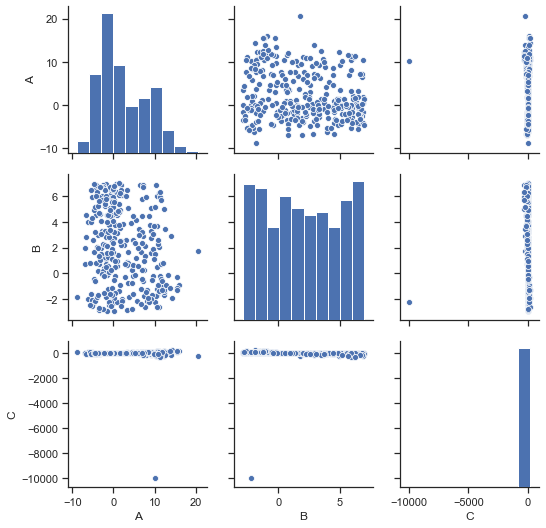

In [24]:
g = sns.pairplot(data_raw)

There seems to be some outiers in the data, the first step to get a good regression model will be to identify those outliers.

But before I will isolate a testing set that I will not touch until my model is finalized. It will be used to score the model and assess its generalization potential. 

### Train-Test split 

Without information on the data I assume there is no order in the observations and I take a random sample of 25% of the data as test set. 

If there was a time stamp I would have to take the 25% last observations to build the test set.

In [150]:
train = data_raw.sample(frac = 0.75, random_state=seed)

test = data_raw.loc[lambda x: ~x.index.isin(train.index)]

print(f'Training set size : {train.shape[0]}, testing set size {test.shape[0]}')

Training set size : 225, testing set size 75


### Outlier detection 

I will use the Inter Quartile Range Method.

The IQR is the difference between the Third quartile and the First quartile.  
This method characterize outliers as datapoints that are outside of the range [Q1 - 1.5 IQR; Q3 + 1.5 IQR]

In [151]:
quartiles_A = train.A.quantile([0,0.25,0.5,0.75, 1])
quartiles_B = train.B.quantile([0,0.25,0.5,0.75, 1])
quartiles_C = train.C.quantile([0,0.25,0.5,0.75, 1])
IQR_A = quartiles_A[0.75] - quartiles_A[0.25]
IQR_B = quartiles_B[0.75] - quartiles_B[0.25]
IQR_C = quartiles_C[0.75] - quartiles_C[0.25]

In [152]:
train_clean = (train
              .loc[lambda x : (x.A >= quartiles_A[0.25]-1.5*IQR_A) & (x.A <= quartiles_A[0.75]+1.5*IQR_A)]
              .loc[lambda x : (x.B >= quartiles_B[0.25]-1.5*IQR_B) & (x.B <= quartiles_B[0.75]+1.5*IQR_B)]
              .loc[lambda x : (x.C >= quartiles_C[0.25]-1.5*IQR_C) & (x.C <= quartiles_C[0.75]+1.5*IQR_C)]
             )
train_clean.shape

(188, 3)

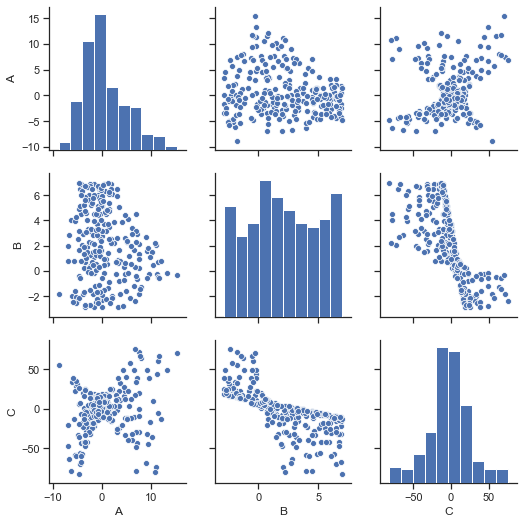

In [86]:
g = sns.pairplot(data_clean)

In [87]:
data_clean.corr().style.background_gradient(cmap='RdBu_r')

,A,B,C
A,1,-0.165938,0.256856
B,-0.165938,1,-0.702125
C,0.256856,-0.702125,1


Since C depends on both A and B there might be some interactions but we can see the obvious outliers have been removed.

There is a high correlation between C and B.

### Feature engineering

**dump**

Computing some simple features to try.

In [63]:
data_aug = (data_clean
            .assign(A_sqrt = lambda x: np.sqrt(np.abs(x.A)),
                    A_log = lambda x: np.log(np.abs(x.A)), 
                    B_sqrt = lambda x: np.sqrt(np.abs(x.B)),
                    B_log = lambda x: np.log(np.abs(x.B)))
           )

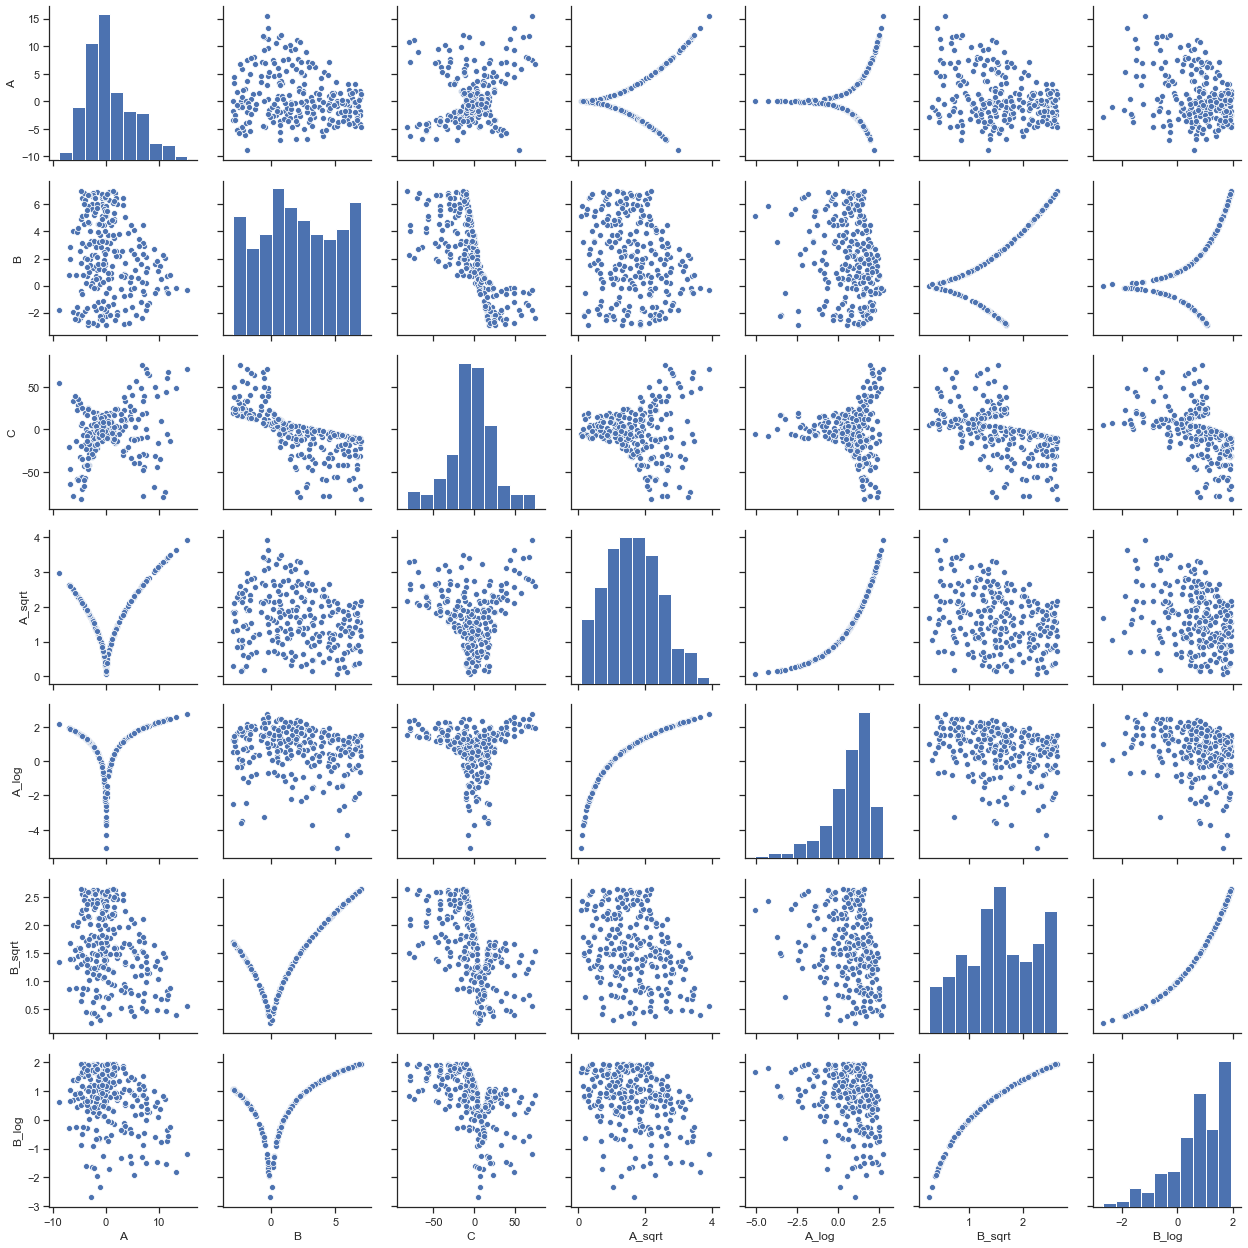

In [64]:
g = sns.pairplot(data_aug)

In [65]:
corr = data_aug.corr()
corr.style.background_gradient(cmap='RdBu_r')

,A,B,C,A_sqrt,A_log,B_sqrt,B_log
A,1,-0.165938,0.256856,0.451876,0.278344,-0.307033,-0.299636
B,-0.165938,1,-0.702125,-0.2302,-0.17702,0.774257,0.656484
C,0.256856,-0.702125,1,-0.0177619,-0.0610236,-0.534639,-0.492301
A_sqrt,0.451876,-0.2302,-0.0177619,1,0.917914,-0.331708,-0.312867
A_log,0.278344,-0.17702,-0.0610236,0.917914,1,-0.268696,-0.255778
B_sqrt,-0.307033,0.774257,-0.534639,-0.331708,-0.268696,1,0.963144
B_log,-0.299636,0.656484,-0.492301,-0.312867,-0.255778,0.963144,1


In [153]:
train.A.describe()

count    225.000000
mean       2.367555
std        5.750211
min       -8.860000
25%       -1.900000
50%        0.421000
75%        7.040000
max       20.600000
Name: A, dtype: float64

### Solution : 

The relationship between C and A, B is more complex than just a linear one.
My idea is to build a linear regression using polynomial features.

Following this basic process to build a model :  
1) Normalize variables  
2) Compute polynomial features  
3) Compute theta the vector of weights of the linear regression model  

I will first experiment with all monomials up to degree d built using A and B. Using Cross validation to find the optimal maximal degree of the monomials.

Then I will select the best subset of features using forward selection and cross validation to score the possible models. 


After that I will visualize the final model prediction and plot the learned regression surface, as well as score it on the test set (only time when it will be used). 

In [92]:
def normalize_feature(x1, center, scale):
    """center and scale vector x1 using the provided mena and standard deviation"""
    res = (x1 - center)/scale
    return res

In [101]:
# normalize_feature(train.A.values, 2.167116, 5.645013)

In [300]:
def generate_polynomial_features(x1,x2,n, intercept = True):
    """ returns a pandas DataFrame of all monomials combination of x1 and x2 up to degree n 
    
    Keyword arguments:
    x1 -- numpy array 
    x2 -- numpy array 
    n -- maximal degree of the monomials 
    intercept -- wether or not to include a colum of ones (default True)
    """
    
    if intercept : 
        start = 0
    else :
        start = 1
    
    f = pd.DataFrame()
    for k in range(start,n+1):
        for j in range(k+1):
                f[f'A{k-j}B{j}'] = ((x2)**j*(x1)**(k-j))
    return f


In [301]:
def get_feature_matrix(df, degree, intercept = True):
    """Compute all polynomial features up to the specified degree
    
    Keyword arguments:
    df -- pandas dataframe containing columns A and B 
    degree -- maximal degree of the monomials 
    intercept -- wether or not to include a colum of ones (default True)
    """
    
    # Get what I need to normalize the original feature
    A_mean, A_std = df.A.mean(), df.A.std()
    B_mean, B_std = df.B.mean(), df.B.std()
    
    # Normalize original feature 
    x1 = normalize_feature(df.A.values, A_mean, A_std)
    x2 = normalize_feature(df.B.values, B_mean, B_std)
    
    # generate the feature matrix 
    H = generate_polynomial_features(x1,x2, degree, intercept)
    
    return H

In [480]:
# `numpy.linalg` has a specialized function `numpy.linalg.lstsq` to solve least square problems.

def fit_lin_reg_coefs(H, Y, reg_param = 0.0):
    """Computes the weights of the independant variables in the linear model  
    
    Keyword arguments:
    H -- numpy array containing the features used for the linear regression
    Y -- numpy array containing the values of the dependant variable
    reg_param -- float equal to the L2 regularization coefficient (default 0.0)
    """
    
    I = np.identity(H.shape[1])
    theta=np.linalg.solve(np.dot(H.T,H) + reg_param*I ,np.dot(H.T,Y))
    return theta 


In [160]:
def get_kfold(df, k, seed):
    """outputs a list of k tuples containing the indexes of the training and validation sets
    
    Keyword arguments:
    df -- pandas Series or dataFrame whose index will split into k folds
    k -- int, number of fold
    seed -- random seed for reproducibility
    """
    N = df.shape[0]
    data = df.copy()
    fold_len = np.int(N/k)
    print(fold_len)
    folds = []
    for i in range(k-1):
        fold = data.sample(n=fold_len, random_state=seed).index
        data  = data.loc[lambda x: ~x.index.isin(fold)]
        folds.append((df.index.difference(fold),fold))
    folds.append((df.index.difference(data.index),data.index))
    
    return folds

In [161]:
check = get_kfold(train, 5, 9)

45


In [124]:
len(check[-1][0])

45

In [505]:
def model_cross_validation(X,Y,folds, reg_param = 0.0):
    """outputs 2 lists of rmse fo the model on each training and validation sets defined by the folds
    
    Keyword arguments:
    X -- pandas dataFrame containing the features to be used in the model 
    Y -- pandas Series or dataFramecontaining the dependant variable values
    folds -- output of get_kfold defining the training and validation sets
    reg_param -- regularization coefficient (default 0.0)
    """
    
    kfolds=len(folds)
    train_performance=np.empty(kfolds)
    validation_performance=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx]
        
        # get the training/validation data in numpy array
        X_train=X.loc[train].values
        Y_train=Y.loc[train].values
        X_validation=X.loc[validation].values 
        Y_validation=Y.loc[validation].values
        
        # get the regression coefficient
        theta = fit_lin_reg_coefs(X_train,Y_train, reg_param)
        
        # compute RMSE
        rmse_train = np.sqrt(np.mean((Y_train-np.dot(X_train,theta))**2))
        rmse_validation = np.sqrt(np.mean((np.dot(X_validation,theta) - Y_validation)**2))
        
        # store result 
        train_performance[idx]=rmse_train
        validation_performance[idx]=rmse_validation
        
    return np.array(train_performance),np.array(validation_performance)

### Implementation and degree selection using 5 fold CV

The first class of model I will try uses all monomials up to a degree d as features.
Using Cross validation I aim to find the optimal value for the max degree of the monomials.

Using the cleaned training set I follow these steps :

- Get the indexes to split the data into 5 folds  
- for degrees from 1 to 20:  
    * compute polynomial features  
    * compute regression coefficients
    * score the model using 5 fold cross validation 
- plot training and validation RMSE to identify optimal degree

#### Checks

In [498]:
k = 5
degree = 1
Y = train_clean.C.reset_index(drop=True)

# get the indexes for cross validation
folds = get_kfold(Y, k, seed)

# build feature matrix 
# H = get_feature_matrix(train_clean, degree)
# Get what I need to normalize the original feature
A_mean, A_std = train_clean.A.mean(), train_clean.A.std()
B_mean, B_std = train_clean.B.mean(), train_clean.B.std()

# Normalize original feature 
x1 = normalize_feature(train_clean.A.values, A_mean, A_std)
x2 = normalize_feature(train_clean.B.values, B_mean, B_std)

# x1 = train_clean.A.values
# x2 = train_clean.B.values

# generate the feature matrix 
H = generate_polynomial_features(x1,x2, degree, intercept=True)

# compute rmse for each fold
t,v=model_cross_validation(H,Y,folds, reg_param = 1)
theta = fit_lin_reg_coefs(H,Y)

print(degree,t.mean(),v.mean(),t.std(),v.std())

37
1 20.519397338060735 20.741483251247114 1.2336832206365391 4.964194960088316


In [347]:
t

array([19.8078257 , 20.36017742, 21.91871859, 18.67709344, 21.83317154])

In [348]:
t,v=model_cross_validation(train_clean[['A','B']].reset_index(drop=True),Y,folds) # no intercept
t

array([20.86934686, 22.20080256, 23.45495467, 20.80784079, 23.08587145])

#### Degree selection 

In [511]:
k = 5
train_avg=[]
train_std=[]
validation_avg=[]
validation_std=[]
degrees= range(1,11)

Y = train_clean.C.reset_index(drop=True)

# get the indexes for cross validation
folds = get_kfold(Y, k, seed)

for degree in degrees:
    H = get_feature_matrix(train_clean, degree)
    t,v=model_cross_validation(H,Y,folds, reg_param = 1)
    train_avg.append(t.mean())
    train_std.append(t.std())
    validation_avg.append(v.mean())
    validation_std.append(v.std())
    print(degree,t.mean(),v.mean(),t.std(),v.std())
validation_avg=np.array(validation_avg)
train_avg=np.array(train_avg)

37
1 20.519810565982688 20.732091546649468 1.2336945523125917 4.990455531475659
2 18.719557505115088 19.127130961840084 1.1329329300633495 4.6724158019238295
3 0.4194609470367669 0.4686639172606954 0.017086383079192934 0.11493949845111379
4 0.516590828399794 0.7853078424689963 0.05845293194778693 0.6135365979924764
5 0.9430047229132781 1.3033936548373006 0.023254985130741087 0.37247048260287097
6 1.027083502055187 2.4311309085358848 0.008656151177516284 2.395672123479309
7 0.973381929768251 1.755077669660876 0.010166035224969545 0.9042455404167372
8 0.8808798258420053 1.975328513854064 0.02028260051531165 1.1535521624941567
9 0.8862013402927508 1.7810901221611786 0.018323603958077583 0.5862565298612167
10 0.9414838541892891 11.737379982078266 0.017215274918400737 17.029284613293864


(0, 10)

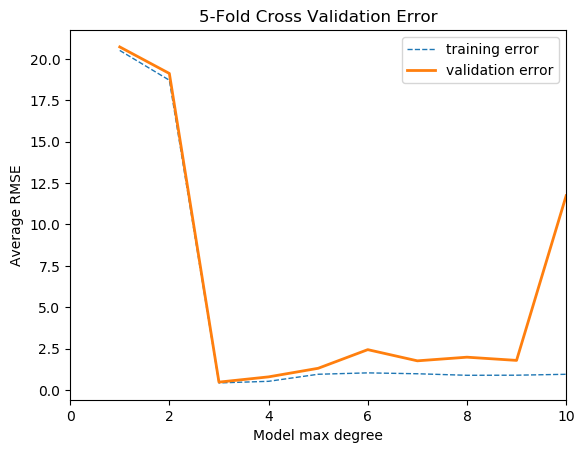

In [561]:
plt.plot(degrees,train_avg,  label='training error ' , linestyle="--",linewidth=1.0  )
plt.plot(degrees, validation_avg, label='validation error',linewidth=2.0)
plt.legend()
plt.title('5-Fold Cross Validation Error')
plt.xlabel("Model max degree")
plt.ylabel("Average RMSE")
plt.xlim([0,10])

(3, 10)

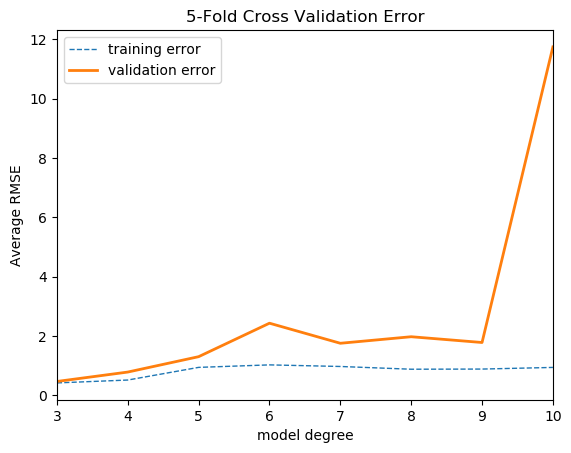

In [513]:
# Zooming in on degress 3 and above

plt.plot(degrees[2:],train_avg[2:],  label='training error ' , linestyle="--",linewidth=1.0  )
plt.plot(degrees[2:], validation_avg[2:], label='validation error',linewidth=2.0)
plt.legend()
plt.title('5-Fold Cross Validation Error')
plt.xlabel("model degree")
plt.ylabel("Average RMSE")
plt.xlim([3,10])

The Training and validation errors starts to diverge at degree 4.  
It means the model starts to overfit at degree 4 so I select 3 as the optimal degree for this class of models.

### Polynomial regression model with optimal degree

The best polynomial reg model is with degree = 3.  
Lets visualize the outputs f the model.

In [569]:
optimal_degree = 3
H = get_feature_matrix(train_clean, optimal_degree)

# get the regression coefficient
theta_final = fit_lin_reg_coefs(H.values,Y, reg_param = 0)

# get predictions
Y_train_preds = np.dot(H,theta_final)

# compute RMSE
rmse_train_final = np.sqrt(np.mean((Y-Y_train_preds)**2))
rmse_train_final

0.08485297592994004

In [565]:
for idx, elem in enumerate(theta_final):
    print(f'coef {H.columns[idx]} : {elem}')
    
# Some coefficients are close to 0, a regularization method sur as LASSO regression would certainly cancel them

coef A0B0 : 4.695246326863797
coef A1B0 : 2.656335581463642
coef A0B1 : -9.280780885455448
coef A2B0 : -17.957340632092908
coef A1B1 : -8.71749322657591
coef A0B2 : 0.008972744262283493
coef A3B0 : -0.003954529018646678
coef A2B1 : -23.906078280183404
coef A1B2 : -0.00016938758723593087
coef A0B3 : -0.0016586743551500215


In [566]:
# Looking at the in sample R squared
r2_train = (np.sum((Y-Y.mean())**2) - np.sum((Y-Y_train_preds)**2))/np.sum((Y-Y.mean())**2)
r2_train

0.9999913801158732

### Optional 
Looking at the distribution of the residuals to check that using a linear modle is justified 

In [570]:
residuals = Y - Y_train_preds

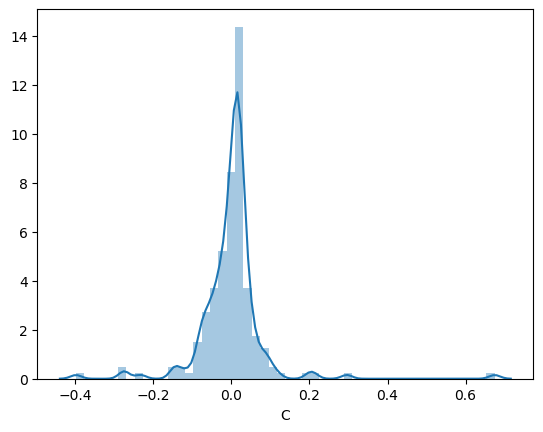

In [571]:
sns.distplot(residuals,kde=True,norm_hist=True)

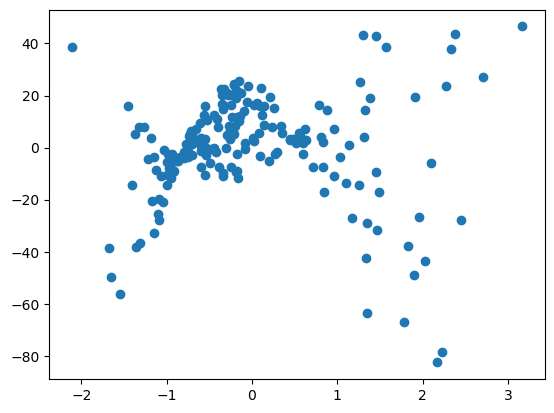

In [443]:
plt.scatter(H['A1B0'],residuals)

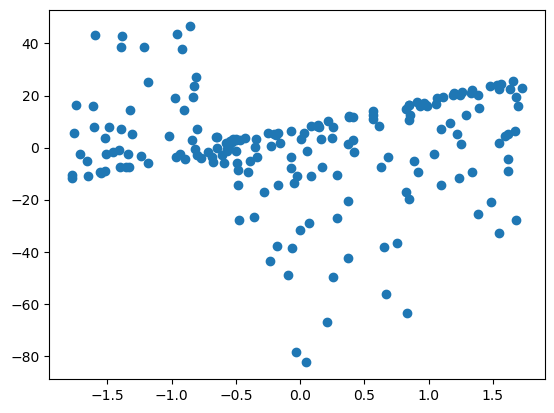

In [451]:
plt.scatter(H['A0B1'],residuals)

### Plotting regression surface

In [438]:
from mpl_toolkits.mplot3d import Axes3D

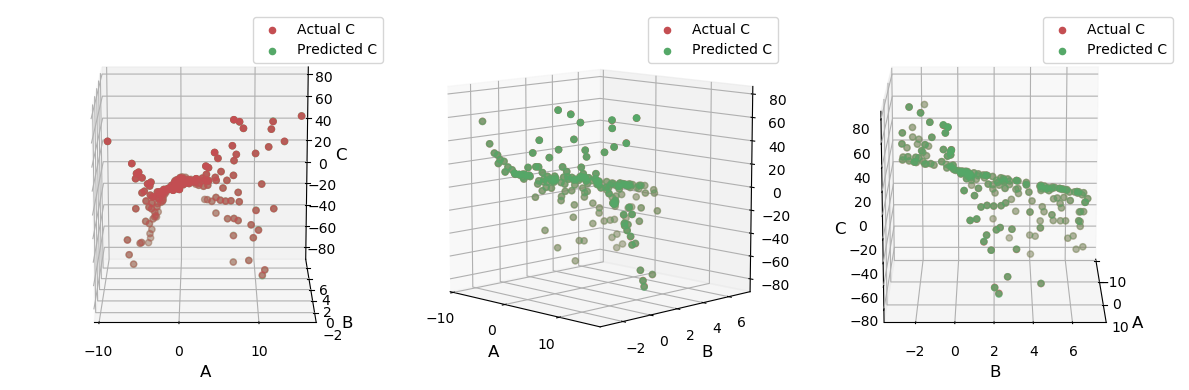

In [572]:
X = train_clean[['A', 'B']].values

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.scatter(X[:, 0], X[:, 1], Y, color='r', label='Actual C')
    ax.scatter(X[:, 0], X[:, 1], Y_train_preds, color='g', label='Predicted C')
    ax.set_xlabel('A', fontsize=12)
    ax.set_ylabel('B', fontsize=12)
    ax.set_zlabel('C', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
    ax.legend()

# ax1.text2D(0.2, 0.32, fontsize=13, ha='center', va='center', transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, fontsize=13, ha='center', va='center', transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, fontsize=13, ha='center', va='center', transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=15, azim=-90)
ax2.view_init(elev=10, azim=-45)
ax3.view_init(elev=15, azim=0)

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

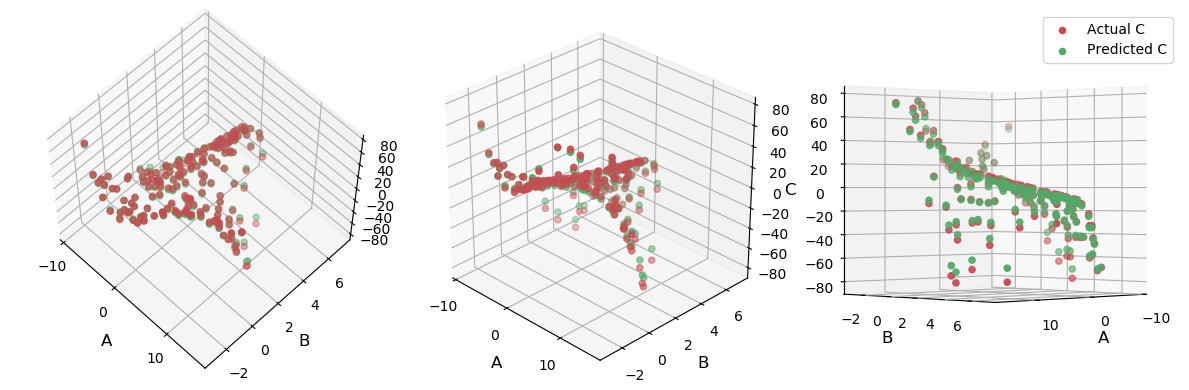

In [492]:
plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.scatter(X[:, 0], X[:, 1], Y, color='r', label='Actual C')
    ax.scatter(X[:, 0], X[:, 1], Y_train_preds, color='g', label='Predicted C')
    ax.set_xlabel('A', fontsize=12)
    ax.set_ylabel('B', fontsize=12)
    ax.set_zlabel('C', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

# ax1.text2D(0.2, 0.32, fontsize=13, ha='center', va='center', transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, fontsize=13, ha='center', va='center', transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, fontsize=13, ha='center', va='center', transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=60, azim=-45)
ax2.view_init(elev=30, azim=-45)
ax3.view_init(elev=0, azim=45)
ax3.legend()

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

Displaying the hyperplan containing the predictions

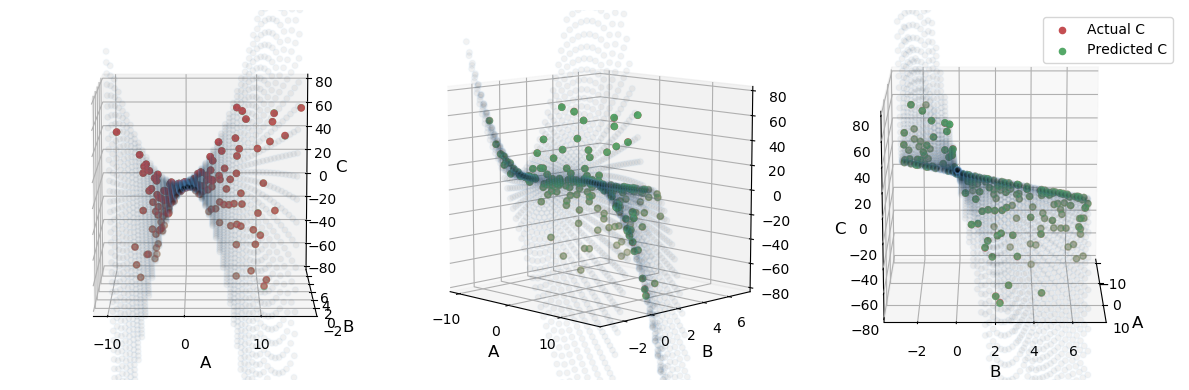

In [573]:
# prepare mesh grid
x_grid = np.linspace(-10, 15, 50)      
y_grid = np.linspace(-3, 7, 50)  
xx_grid, yy_grid = np.meshgrid(x_grid, y_grid)

# Compute prediction for this mesh grid :
A_mean, A_std = train_clean.A.mean(), train_clean.A.std()
B_mean, B_std = train_clean.B.mean(), train_clean.B.std()

# Normalize using original values 
x1 = normalize_feature(xx_grid.flatten(), A_mean, A_std)
x2 = normalize_feature(yy_grid.flatten(), B_mean, B_std)

# generate the feature matrix 
H_grid = generate_polynomial_features(x1,x2, optimal_degree, intercept=True)

Z = np.dot(H_grid,theta_final)


plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.scatter(xx_grid.flatten(), yy_grid.flatten(), Z.flatten(), facecolor=(0,0,0,0),
               s=20, edgecolor='#70b3f0', alpha = 0.05)
    ax.scatter(X[:, 0], X[:, 1], Y, color='r', label='Actual C')
    ax.scatter(X[:, 0], X[:, 1], Y_train_preds, color='g', label='Predicted C')
    ax.set_xlabel('A', fontsize=12)
    ax.set_ylabel('B', fontsize=12)
    ax.set_zlabel('C', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
    ax.set_zlim((-80,80))

# ax1.text2D(0.2, 0.32, fontsize=13, ha='center', va='center', transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, fontsize=13, ha='center', va='center', transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, fontsize=13, ha='center', va='center', transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=10, azim=-90)
ax2.view_init(elev=10, azim=-45)
ax3.view_init(elev=15, azim=0)
ax3.legend()

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

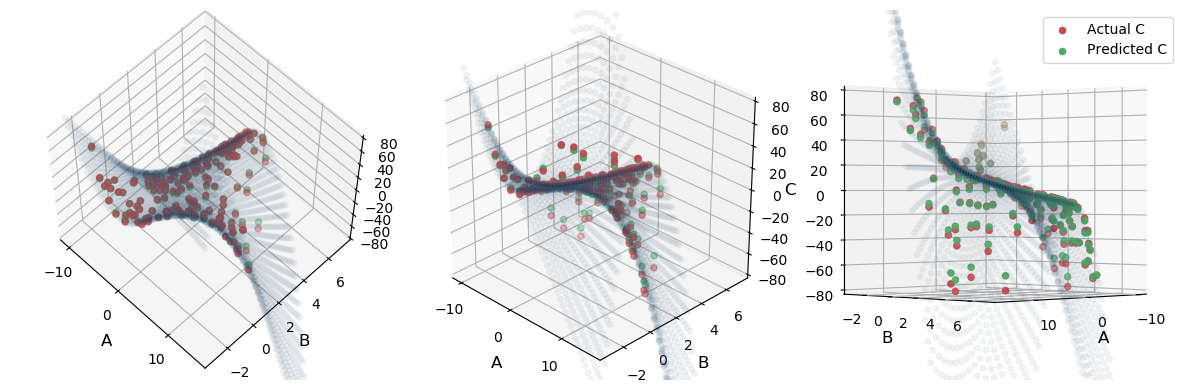

In [517]:
plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.scatter(xx_grid.flatten(), yy_grid.flatten(), Z.flatten(), facecolor=(0,0,0,0),
               s=20, edgecolor='#70b3f0', alpha = 0.05)
    ax.scatter(X[:, 0], X[:, 1], Y, color='r', label='Actual C')
    ax.scatter(X[:, 0], X[:, 1], Y_train_preds, color='g', label='Predicted C')
    ax.set_xlabel('A', fontsize=12)
    ax.set_ylabel('B', fontsize=12)
    ax.set_zlabel('C', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
    ax.set_zlim((-80,80))

# ax1.text2D(0.2, 0.32, fontsize=13, ha='center', va='center', transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, fontsize=13, ha='center', va='center', transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, fontsize=13, ha='center', va='center', transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=60, azim=-45)
ax2.view_init(elev=30, azim=-45)
ax3.view_init(elev=0, azim=45)
ax3.legend()

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

As expected considering the very high R², the model fits every datapoints almost perfectly, this might indicate overfitting : the model is to flexible and fits the training set perfectly but lacks generalization power because it learns noisy details and not just real features. 

Using cross validation is a way to avoid overfitting but in this case we might still be overfitting. 

I will now perform forward feature selection to try and reduce the number of feature used, it will make the model simpler and more generalizable.

The alternative would be to use a regularization technic to constrain the model into learning only relevant features. 

Finally it is possible that our model is already learning relevant features and would perform well on out of sample data, as the cross validated score seem to indicate. 

### Learning Algorithm

In this notebook assume the following model
$$
     y = \sum_{d=0}^{D} h_d(x) \theta_d  + \epsilon
$$
where **$D=10$**, $\epsilon$ is a Gaussian noise term, and the *feature functions* $h_d$ are defined as follows

$$
    h_d(x) = \cos(d \pi x)
$$

[HINT] Note that $d$ runs from **0** to $D$, so there are $D+1$ features in total

You will  work out in  the homework the **cross entropy loss function** for this problem.
It is:

$$
    E = \frac{1}{2N}\sum_i \left( y_i -\hat{y_i} \right)^2
$$
where the predicted $Y$ is 

$$
    \hat{y}_i = \sum_d h_d(x_i)\theta_d= \sum_d H_{i,d}\theta_d
$$
with
$$
    H_{i,d} = h_d(x_i)=\cos(\pi d x_i)
$$
The solution for $\theta$ must satisfy
$$
 (H^T H)  \theta = H^T Y
$$

**[Note]** In the max likelihood derivation there is a common variance $\sigma^2$ factor.  As a scale it does not effect the estimate value of $\theta$, so we will ignore it.


With the definitions the problem of finding  the optimal values of the parameters $\theta_k$  reduces to a simple linear least squares optimization problem that can be solved analytically:

Defining
\begin{align}
    H_{i,k} =& h_k(x_i)
\end{align}
the least squates solution is
$$
        \hat{\Theta} = (H^T H)^{-1} H^T Y
$$
and our best hypothesis is, therefore
$$
    \hat{h}(x) = \sum_{k=0}^{2K+1}  h_k(x) \hat{\theta_k}
$$

In [88]:
# `numpy.linalg` has a specialized function `numpy.linalg.lstsq` to solve lsq problems.
res=np.linalg.lstsq( H,Y,rcond=-1)
theta_exact=res[0]
theta_exact

NameError: name 'H' is not defined

In [ ]:
# coefficients 
for idx in range(len(theta_exact)):
    print(idx,theta_exact[idx],theta_exact2[idx])

In [ ]:
# looking at the predicted value 
Y_pred=np.dot(H,theta_exact)

In [ ]:
plt.scatter(X,Y,label="Y")
plt.scatter(X,Y_pred,label="Y_pred")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Values")
plt.legend()

In [ ]:
# Computing the residuals 

dY=Y-Y_pred
plt.scatter(X,dY,label="Y")

In [ ]:
# RMSE
np.mean(dY**2)

### Checking on sk learn

In [261]:
import sklearn.linear_model

model=sklearn.linear_model.LinearRegression(fit_intercept=True, C = 0.1, )
model.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [262]:
Y_sk = model.predict(X)
dY=(Y_sk-Y_pred)
np.dot(dY.T,dY)/len(dY)

1.5138007334139926e-29

In [263]:
rmse_sk = np.sqrt(np.mean((Y_sk-Y)**2))

In [264]:
rmse_sk

22.15744138713474

In [530]:
model_l1 = sklearn.linear_model.Lasso(alpha=1, fit_intercept=True, random_state=9)
model_l1.fit(H,Y)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=9, selection='cyclic',
      tol=0.0001, warm_start=False)

In [531]:
model_l1.coef_

array([  0.        ,   0.03535311,  -6.32928006, -15.27453299,
        -5.62915418,   0.        ,   0.23758695, -22.12102018,
         1.59078272,  -0.9145831 ])

In [534]:
Y_l1_sk = model_l1.predict(H)

np.sqrt(np.mean((Y_l1_sk-Y)**2))

3.224395425414311

In [536]:
model_l1.score(H,Y)

0.9875530236648418

In [533]:
theta_final

array([ 2.13497209e+00,  1.56851853e+00, -7.97062335e+00, -1.50356359e+01,
       -6.38614701e+00,  1.37865780e+00, -1.00168643e-02, -2.12285234e+01,
        1.96176150e+00, -6.50042505e-01])

### Forward feature selection

The objective is to reduce the size of the model and improve its performances.

- using L1 regularization on sklearn will allow me to perform feature selection and see if there is room for improvement 
- implementing forward 

In [574]:
def forward_selection(X,Y):
    '''perform forward selection and returns the list of selected features and cross validated score 
    of the corresponding model 
    
    Keyword inputs :
    X -- pandas DataFrame containing the features
    Y -- pandas Series containing the dependant variable 
    '''
    
    features = X.columns.to_list()
    remaining_features=features[:]
    features_kept=[]
    best_error=1e10
    count=0
    folds = get_kfold(Y, 5, seed)
    
    while len(remaining_features)>0:
        err_min=1e10 # large number
        feature_candidate=None
        for feature in remaining_features:
            #print("REMAINING:", remaining_features)
            #print("KEPT: ",features_kept)
            #print("TRYING:",feature)
            #print("CANDIDATE",feature_candidate)
            features_tried=features_kept+[feature]
            t,v=model_cross_validation(X[features_tried],Y,folds, reg_param = 1)
            err=v.mean()
            #print(err,err_min)
            
            if (err<err_min):
                feature_candidate=feature
                err_min=err
                
        if err_min<best_error: # accept new feature
            features_kept.append(feature_candidate)
            remaining_features.remove(feature_candidate)
            best_error=err_min
        else: # we did not improve on the valuation set, stop searching
            break
    return features_kept,best_error

In [584]:
k = 5
max_degree = 6

Y = train_clean.C.reset_index(drop=True)

H_all_feats = get_feature_matrix(train_clean, max_degree)
forward_sel_features, best_rmse =forward_selection(H_all_feats,Y)
print(f'{len(forward_sel_features)} features selected\nMin RMSE on 5 fold CV : {best_rmse}')

37
7 features selected
Min RMSE on 5 fold CV : 0.44900147581501726


In [585]:
forward_sel_features

['A2B3', 'A0B1', 'A2B0', 'A2B1', 'A1B1', 'A0B0', 'A1B0']

In [586]:
H_fwd_sel = H_all_feats[forward_sel_features]

theta_fwd_sel = fit_lin_reg_coefs(H_fwd_sel.values,Y, reg_param = 10)

# get predictions
Y_train_preds = np.dot(H_fwd_sel,theta_fwd_sel)

# compute RMSE
rmse_train_fwd_sel = np.sqrt(np.mean((Y-Y_train_preds)**2))
rmse_train_fwd_sel

for idx, elem in enumerate(theta_fwd_sel):
    print(f'coef {H_fwd_sel.columns[idx]} : {elem}')
    
r2_train_fwd_sel = (np.sum((Y-Y.mean())**2) - np.sum((Y-Y_train_preds)**2))/np.sum((Y-Y.mean())**2)
r2_train_fwd_sel

coef A2B3 : -2.0122833183326407
coef A0B1 : -8.918212833369163
coef A2B0 : -15.599310031233067
coef A2B1 : -19.277874807071534
coef A1B1 : -8.300223430111243
coef A0B0 : 3.1004319579530906
coef A1B0 : 2.856482444261587


0.9915524331698169

In [598]:
# Adjusted R²
n_feats = len(forward_sel_features) - 1 # we don't take the constant into account
adj_r2_train_fwd_sel = 1 - ((1 - r2_train_fwd_sel)*(Y.shape[0]-1))/(Y.shape[0]-n_feats-1)
print(f'Train set adjusted R² :{adj_r2_train_fwd_sel}')

Train set adjusted R² :0.9912724033301423


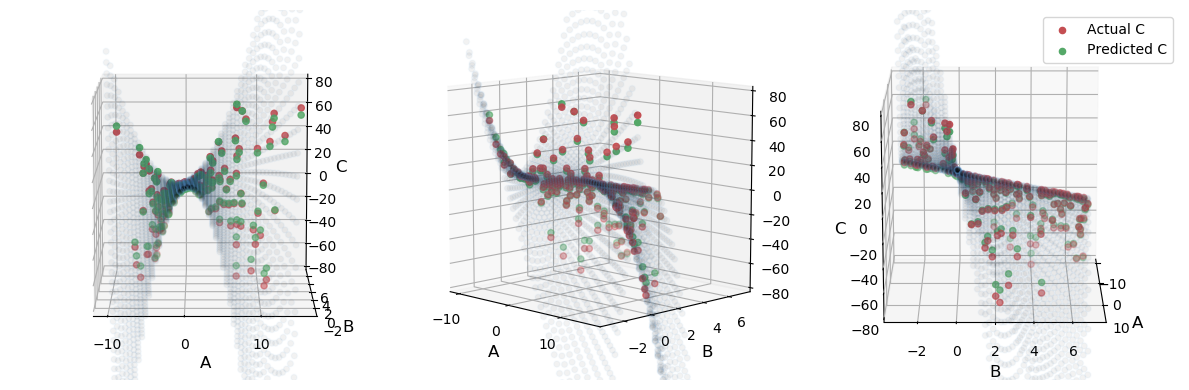

In [587]:
H_grid_fwd_sel = generate_polynomial_features(x1,x2, 6, intercept=True)[forward_sel_features]

Z_fwd_sel = np.dot(H_grid_fwd_sel,theta_fwd_sel)

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.scatter(xx_grid.flatten(), yy_grid.flatten(), Z.flatten(), facecolor=(0,0,0,0),
               s=20, edgecolor='#70b3f0', alpha = 0.05)
    ax.scatter(X[:, 0], X[:, 1], Y, color='r', label='Actual C')
    ax.scatter(X[:, 0], X[:, 1], Y_train_preds, color='g', label='Predicted C')
    ax.set_xlabel('A', fontsize=12)
    ax.set_ylabel('B', fontsize=12)
    ax.set_zlabel('C', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
    ax.set_zlim((-80,80))

# ax1.text2D(0.2, 0.32, fontsize=13, ha='center', va='center', transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, fontsize=13, ha='center', va='center', transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, fontsize=13, ha='center', va='center', transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=10, azim=-90)
ax2.view_init(elev=10, azim=-45)
ax3.view_init(elev=15, azim=0)
# ax1.view_init(elev=60, azim=-45)
# ax2.view_init(elev=30, azim=-45)
# ax3.view_init(elev=0, azim=45)
ax3.legend()

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

### Scoring the final model on the test set  

In [597]:
Y_test = test.C.reset_index(drop=True)

# generate polynomial features for the test set 
x1_t = normalize_feature(test.A.values, A_mean, A_std)
x2_t = normalize_feature(test.B.values, B_mean, B_std)

# generate the feature matrix 
H_test = generate_polynomial_features(x1_t,x2_t, max_degree, intercept=True)[forward_sel_features]

# get predictions
Y_test_preds = np.dot(H_test,theta_fwd_sel)

# compute RMSE
rmse_test_fwd_sel = np.sqrt(np.mean((Y_test-Y_test_preds)**2))
print(f'Test set RMSE : {rmse_test_fwd_sel}')

# compute out of sample R squared
r2_test_fwd_sel = (np.sum((Y_test-Y_test.mean())**2) - np.sum((Y_test-Y_test_preds)**2))/np.sum((Y_test-Y_test.mean())**2)
print(f'Test set R² :{r2_test_fwd_sel}')

# Adjusted R²
n_obs = test.shape[0]
n_feats = len(forward_sel_features) - 1 # we don't take the constant into account
adj_r2_test_fwd_sel = 1 - ((1 - r2_test_fwd_sel)*(n_obs-1))/(n_obs-n_feats-1)
print(f'Test set adjusted R² :{adj_r2_test_fwd_sel}')

Test set RMSE : 6.517343818320876
Test set R² :0.9940641105244606
Test set adjusted R² :0.9935403555707366


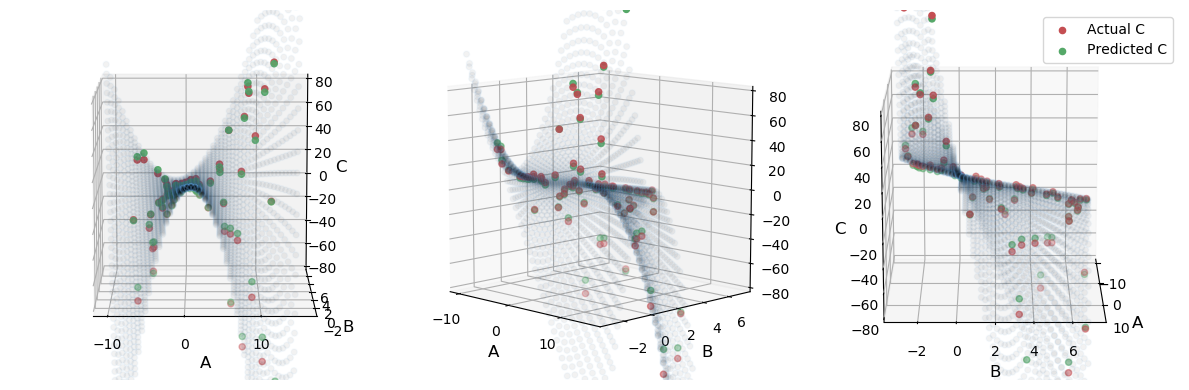

In [559]:

print(f'Test set R² :{r2_test_fwd_sel}')plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.scatter(xx_grid.flatten(), yy_grid.flatten(), Z.flatten(), facecolor=(0,0,0,0),
               s=20, edgecolor='#70b3f0', alpha = 0.05)
    ax.scatter(test.iloc[:, 0], test.iloc[:, 1], Y_test, color='r', label='Actual C')
    ax.scatter(test.iloc[:, 0], test.iloc[:, 1], Y_test_preds, color='g', label='Predicted C')
    ax.set_xlabel('A', fontsize=12)
    ax.set_ylabel('B', fontsize=12)
    ax.set_zlabel('C', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
    ax.set_zlim((-80,80))

# ax1.text2D(0.2, 0.32, fontsize=13, ha='center', va='center', transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, fontsize=13, ha='center', va='center', transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, fontsize=13, ha='center', va='center', transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=10, azim=-90)
ax2.view_init(elev=10, azim=-45)
ax3.view_init(elev=15, azim=0)
# ax1.view_init(elev=60, azim=-45)
# ax2.view_init(elev=30, azim=-45)
# ax3.view_init(elev=0, azim=45)
ax3.legend()

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

Out of sample performance is lower than the cross validated score as expected. 
But still very high with an out of sample adjusted R² of 0.99

The model seem to work well on the testing set, the potential issue when using it on unseen data is that the training data was not fully represnetative of the actual data and therefore the model will not perform as well as expected. 